In [ ]:
!pip install geopandas pandas shapely matplotlib 

In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import LineString, box
import matplotlib.pyplot as plt

# --- Paths to shapefiles ---
states_path = "/home/njm12/ATMS_596/ne_10m_admin_1_states_provinces.shp"
rivers_path = "/home/njm12/ATMS_596/ne_10m_rivers_lake_centerlines.shp"
tornadoes_path = "/home/njm12/ATMS_596/1950-2024_actual_tornadoes.csv"

# --- Read shapefiles ---
states = gpd.read_file(states_path)
rivers = gpd.read_file(rivers_path)


In [2]:
# Keep only Mississippi River segments
mississippi = rivers[rivers["name_en"].str.contains("Mississippi", case=False, na=False)].copy()

# --- Read tornado CSV ---
df = pd.read_csv(tornadoes_path)

# Convert date column to datetime and filter
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df_midwest = df[(df["st"].isin(["IL", "IA", "MO"])) &
                (df["date"] > "2007-02-01") &
                (df["mag"].isin([0,1,2]))].copy()  # Only weak tornadoes EF0-2

# Replace missing end coordinates with start coordinates
df_midwest.loc[(df_midwest["elat"].isna()) | (df_midwest["elon"].isna()) |
               (df_midwest["elat"]==0) | (df_midwest["elon"]==0),
               ["elat", "elon"]] = df_midwest.loc[(df_midwest["elat"].isna()) | (df_midwest["elon"].isna()) |
                                                  (df_midwest["elat"]==0) | (df_midwest["elon"]==0),
                                                  ["slat", "slon"]].values


In [3]:
# Build geometries for tornado tracks
geoms = [LineString([(row["slon"], row["slat"]), (row["elon"], row["elat"])]) for _, row in df_midwest.iterrows()]
gdf_tornadoes = gpd.GeoDataFrame(df_midwest, geometry=geoms, crs="EPSG:4326")

# --- Project everything to a meter-based CRS (Conus Albers Equal Area) ---
proj_crs = "EPSG:5070"
gdf_tornadoes = gdf_tornadoes.to_crs(proj_crs)
mississippi = mississippi.to_crs(proj_crs)

In [4]:
# --- Statistics ---
total_tornadoes = len(gdf_tornadoes)
counts_by_ef = gdf_tornadoes["mag"].value_counts().sort_index()

# Convert path length and width to meters (1 mile = 1609.34 m, 1 yard = 0.9144 m)
gdf_tornadoes["len_m"] = gdf_tornadoes["len"] * 1609.34
gdf_tornadoes["wid_m"] = gdf_tornadoes["wid"] * 0.9144

avg_len_width = gdf_tornadoes.groupby("mag")[["len_m","wid_m"]].mean()

In [5]:
# --- Tornadoes crossing Mississippi River along IL ---
# Limit Mississippi to section that borders Illinois
il_shape = states[states["postal"]=="IL"].to_crs(proj_crs)
mississippi_il = gpd.overlay(mississippi, il_shape, how='intersection')

# Count tornadoes intersecting the IL section of Mississippi
river_union = mississippi_il.geometry.union_all()  # updated method
crossings = gdf_tornadoes[gdf_tornadoes.intersects(river_union)]
crossings_counts_by_ef = crossings["mag"].value_counts().sort_index()

In [6]:
# --- Create a 20 km wide buffer box around Mississippi IL section ---
buffer_distance = 10000  # 10 km on each side
mississippi_buffer = mississippi_il.buffer(buffer_distance)
# Merge all segments into a single polygon for the bounding box
box_union = mississippi_buffer.geometry.union_all()

# Tornadoes within or intersecting the box
tornadoes_in_box = gdf_tornadoes[gdf_tornadoes.intersects(box_union)]
tornadoes_box_counts_by_ef = tornadoes_in_box["mag"].value_counts().sort_index()

In [9]:
# --- Print results ---
print(f"Total weak tornadoes (EF0-2): {total_tornadoes}")
print("Counts by EF-scale:")
print(counts_by_ef)
print("\nAverage path length (m) and width (m) by EF-scale:")
print(avg_len_width.round(3))
print("\nTornadoes crossing Mississippi (IL section) - total:", len(crossings))
print("Counts by EF-scale for river crossings:")
print(crossings_counts_by_ef)
print("\nTornadoes within 20km box around Mississippi (IL) - total:", len(tornadoes_in_box))
print("Counts by EF-scale within box:")
print(tornadoes_box_counts_by_ef)


Total weak tornadoes (EF0-2): 2643
Counts by EF-scale:
mag
0    1364
1    1021
2     258
Name: count, dtype: int64

Average path length (m) and width (m) by EF-scale:
         len_m    wid_m
mag                    
0     2816.758   57.431
1     7835.121  137.627
2    15651.892  264.864

Tornadoes crossing Mississippi (IL section) - total: 3
Counts by EF-scale for river crossings:
mag
1    3
Name: count, dtype: int64

Tornadoes within 20km box around Mississippi (IL) - total: 55
Counts by EF-scale within box:
mag
0    18
1    28
2     9
Name: count, dtype: int64


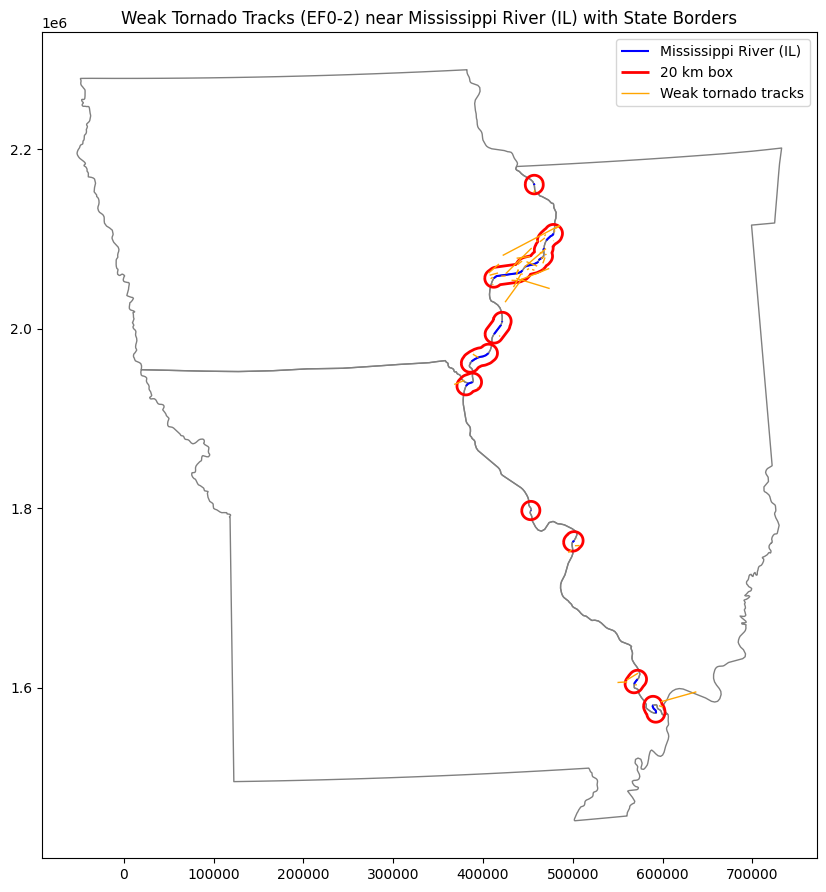

In [10]:
# Filter for relevant US Midwest states by name
midwest_states = states[states['name'].isin(['Illinois','Iowa','Missouri'])].copy()

# Project to CRS
midwest_states = midwest_states.to_crs(proj_crs)

# --- Plot tornado tracks in buffered box ---
fig, ax = plt.subplots(figsize=(10,12))

# Plot state borders in light gray
midwest_states.plot(ax=ax, color="none", edgecolor="gray", linewidth=1)

# Mississippi IL section
mississippi_il.plot(ax=ax, color="blue", label="Mississippi River (IL)")

# 20 km buffer box
gpd.GeoSeries([box_union], crs=proj_crs).boundary.plot(ax=ax, color="red", linewidth=2, label="20 km box")

# Tornado tracks inside box
tornadoes_in_box.plot(ax=ax, color="orange", linewidth=1, label="Weak tornado tracks")

ax.set_title("Weak Tornado Tracks (EF0-2) near Mississippi River (IL) with State Borders")
ax.legend()
plt.show()

Tornadoes within exact 20 km wide rectangle - total: 829
Counts by EF-scale within rectangle:
mag
0    375
1    365
2     89
Name: count, dtype: int64


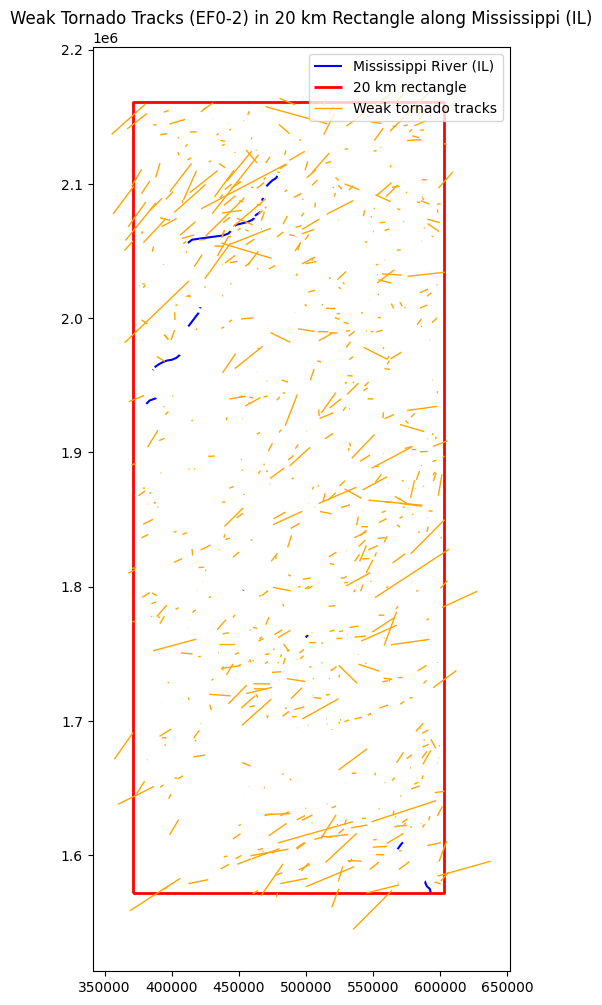

In [11]:
from shapely.geometry import Polygon, box
from shapely.affinity import translate

# --- Create exact rectangular bounding box around Mississippi (IL) ---
# Step 1: get the bounding line of the river along IL
mississippi_il_line = mississippi_il.geometry.union_all()  # merged river geometry

# Step 2: get the bounds of the river line
minx, miny, maxx, maxy = mississippi_il_line.bounds

# Step 3: expand 10 km west (minx) and 10 km east (maxx)
minx_box = minx - 10000  # 10 km west
maxx_box = maxx + 10000  # 10 km east

# Step 4: create rectangular polygon
rect_box = box(minx_box, miny, maxx_box, maxy)  # minx, miny, maxx, maxy

# --- Tornadoes intersecting the rectangle ---
tornadoes_in_rect = gdf_tornadoes[gdf_tornadoes.intersects(rect_box)]
tornadoes_rect_counts_by_ef = tornadoes_in_rect["mag"].value_counts().sort_index()

# --- Print counts ---
print("Tornadoes within exact 20 km wide rectangle - total:", len(tornadoes_in_rect))
print("Counts by EF-scale within rectangle:")
print(tornadoes_rect_counts_by_ef)

# --- Plot tornado tracks in the rectangle with Mississippi River and rectangle ---
fig, ax = plt.subplots(figsize=(10, 12))
mississippi_il.plot(ax=ax, color="blue", label="Mississippi River (IL)")
gpd.GeoSeries([rect_box], crs=proj_crs).boundary.plot(ax=ax, color="red", linewidth=2, label="20 km rectangle")
tornadoes_in_rect.plot(ax=ax, color="orange", linewidth=1, label="Weak tornado tracks")
ax.set_title("Weak Tornado Tracks (EF0-2) in 20 km Rectangle along Mississippi (IL)")
ax.legend()
plt.show()

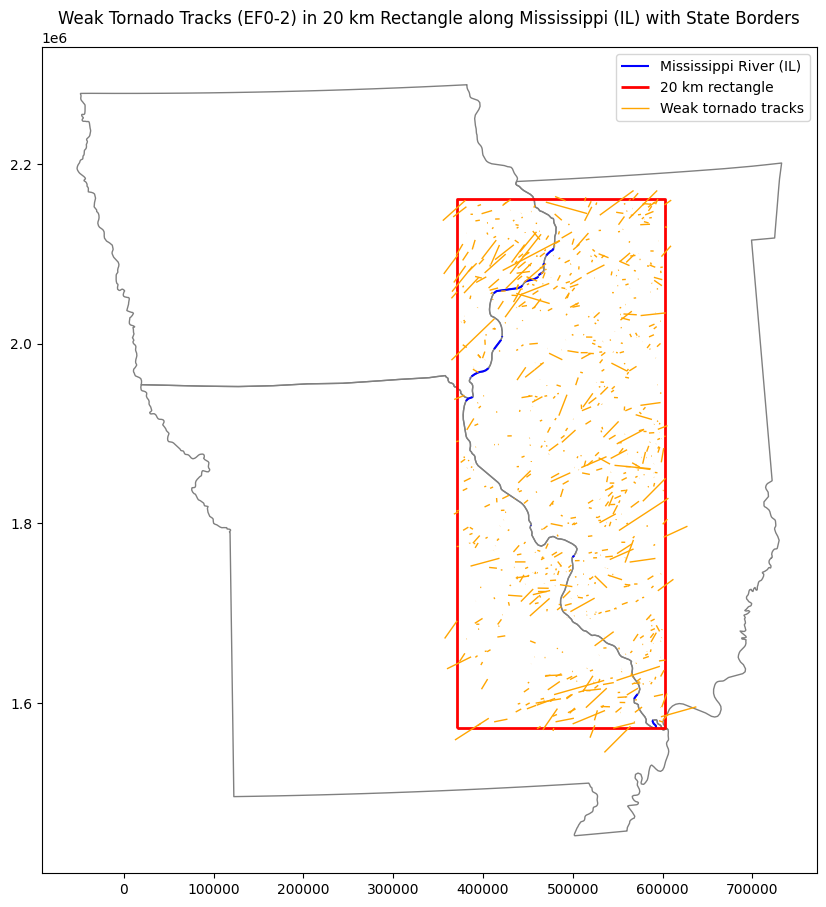

In [12]:
# --- Plot tornado tracks in exact rectangle ---
fig, ax = plt.subplots(figsize=(10,12))

midwest_states.plot(ax=ax, color="none", edgecolor="gray", linewidth=1)
mississippi_il.plot(ax=ax, color="blue", label="Mississippi River (IL)")
gpd.GeoSeries([rect_box], crs=proj_crs).boundary.plot(ax=ax, color="red", linewidth=2, label="20 km rectangle")
tornadoes_in_rect.plot(ax=ax, color="orange", linewidth=1, label="Weak tornado tracks")

ax.set_title("Weak Tornado Tracks (EF0-2) in 20 km Rectangle along Mississippi (IL) with State Borders")
ax.legend()
plt.show()

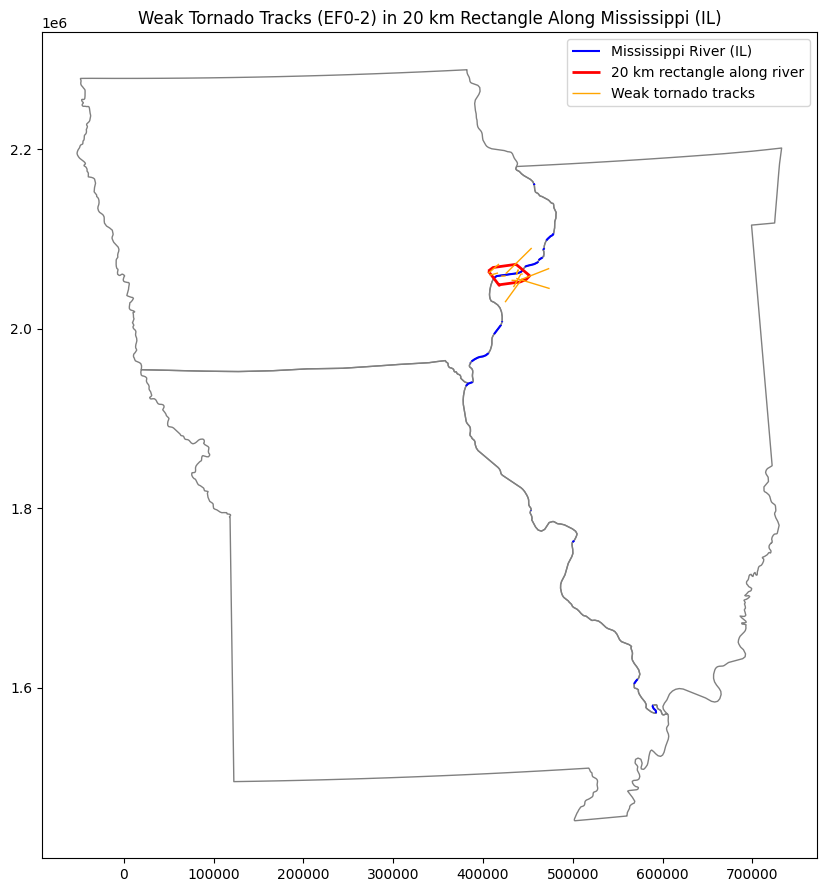

Tornadoes in rotated 20 km rectangle - total: 14
Counts by EF-scale within rectangle:
mag
0    4
1    8
2    2
Name: count, dtype: int64


In [13]:
from shapely.geometry import LineString, Polygon

# Merge Mississippi IL segments into one geometry
river_geom = mississippi_il.geometry.union_all()

# Ensure it's a single LineString
if river_geom.geom_type == "MultiLineString":
    # Take the longest individual LineString
    river_line = max(river_geom.geoms, key=lambda l: l.length)
elif river_geom.geom_type == "LineString":
    river_line = river_geom
else:
    raise ValueError(f"Unexpected geometry type: {river_geom.geom_type}")

# Create parallel lines 10 km left and right
left_line = river_line.parallel_offset(10000, 'left', join_style=2)
right_line = river_line.parallel_offset(10000, 'right', join_style=2)

# Create polygon by connecting endpoints
coords = list(left_line.coords) + list(right_line.coords)[::-1]  # reverse right side
rect_river = Polygon(coords)

# Tornadoes intersecting the rotated rectangle
tornadoes_in_rect = gdf_tornadoes[gdf_tornadoes.intersects(rect_river)]
tornadoes_rect_counts_by_ef = tornadoes_in_rect["mag"].value_counts().sort_index()

# --- Plot ---
fig, ax = plt.subplots(figsize=(10,12))
midwest_states.plot(ax=ax, color="none", edgecolor="gray", linewidth=1)
mississippi_il.plot(ax=ax, color="blue", label="Mississippi River (IL)")
gpd.GeoSeries([rect_river], crs=proj_crs).boundary.plot(ax=ax, color="red", linewidth=2, label="20 km rectangle along river")
tornadoes_in_rect.plot(ax=ax, color="orange", linewidth=1, label="Weak tornado tracks")
ax.set_title("Weak Tornado Tracks (EF0-2) in 20 km Rectangle Along Mississippi (IL)")
ax.legend()
plt.show()

# Print counts
print("Tornadoes in rotated 20 km rectangle - total:", len(tornadoes_in_rect))
print("Counts by EF-scale within rectangle:")
print(tornadoes_rect_counts_by_ef)

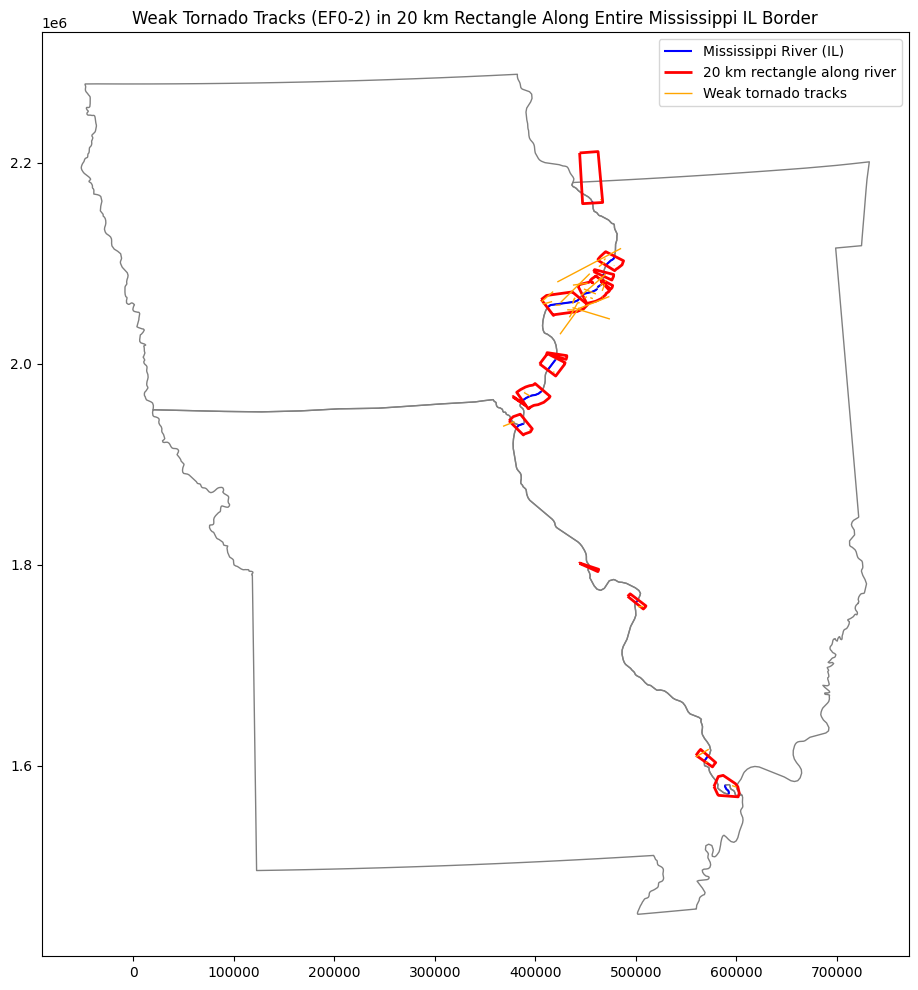

Tornadoes in 20 km rectangle along entire Mississippi IL border - total: 41
Counts by EF-scale within rectangle:
mag
0    11
1    23
2     7
Name: count, dtype: int64


In [14]:
from shapely.ops import unary_union
from shapely.geometry import Polygon, LineString, MultiLineString

# Merge all Mississippi IL segments into one geometry
river_geom = mississippi_il.geometry.union_all()

# Make sure we have a list of LineStrings
if river_geom.geom_type == "LineString":
    river_lines = [river_geom]
elif river_geom.geom_type == "MultiLineString":
    river_lines = list(river_geom.geoms)
else:
    raise ValueError(f"Unexpected geometry type: {river_geom.geom_type}")

polygons = []

for line in river_lines:
    # Offset 10 km left
    left_offset = line.parallel_offset(10000, 'left', join_style=2)
    # Offset 10 km right
    right_offset = line.parallel_offset(10000, 'right', join_style=2)

    # Function to extract coords from LineString or MultiLineString
    def get_coords(geom):
        if geom.geom_type == "LineString":
            return list(geom.coords)
        elif geom.geom_type == "MultiLineString":
            coords = []
            for l in geom.geoms:
                coords.extend(list(l.coords))
            return coords
        else:
            raise ValueError(f"Unexpected geometry type: {geom.geom_type}")

    left_coords = get_coords(left_offset)
    right_coords = get_coords(right_offset)[::-1]  # reverse right side

    # Create polygon for this segment
    polygons.append(Polygon(left_coords + right_coords))

# Combine all segment polygons into one
rect_river_full = unary_union(polygons)

# Tornadoes intersecting the full rectangle
tornadoes_in_rect_full = gdf_tornadoes[gdf_tornadoes.intersects(rect_river_full)]
tornadoes_rect_counts_by_ef_full = tornadoes_in_rect_full["mag"].value_counts().sort_index()

# --- Plot ---
fig, ax = plt.subplots(figsize=(12,12))
midwest_states.plot(ax=ax, color="none", edgecolor="gray", linewidth=1)
mississippi_il.plot(ax=ax, color="blue", label="Mississippi River (IL)")
gpd.GeoSeries([rect_river_full], crs=proj_crs).boundary.plot(ax=ax, color="red", linewidth=2, label="20 km rectangle along river")
tornadoes_in_rect_full.plot(ax=ax, color="orange", linewidth=1, label="Weak tornado tracks")
ax.set_title("Weak Tornado Tracks (EF0-2) in 20 km Rectangle Along Entire Mississippi IL Border")
ax.legend()
plt.show()

# Print counts
print("Tornadoes in 20 km rectangle along entire Mississippi IL border - total:", len(tornadoes_in_rect_full))
print("Counts by EF-scale within rectangle:")
print(tornadoes_rect_counts_by_ef_full)

Tornadoes intersecting continuous 20 km buffer along IL Mississippi - total: 119
Counts by EF-scale within buffer:
mag
0    47
1    51
2    21
Name: count, dtype: int64


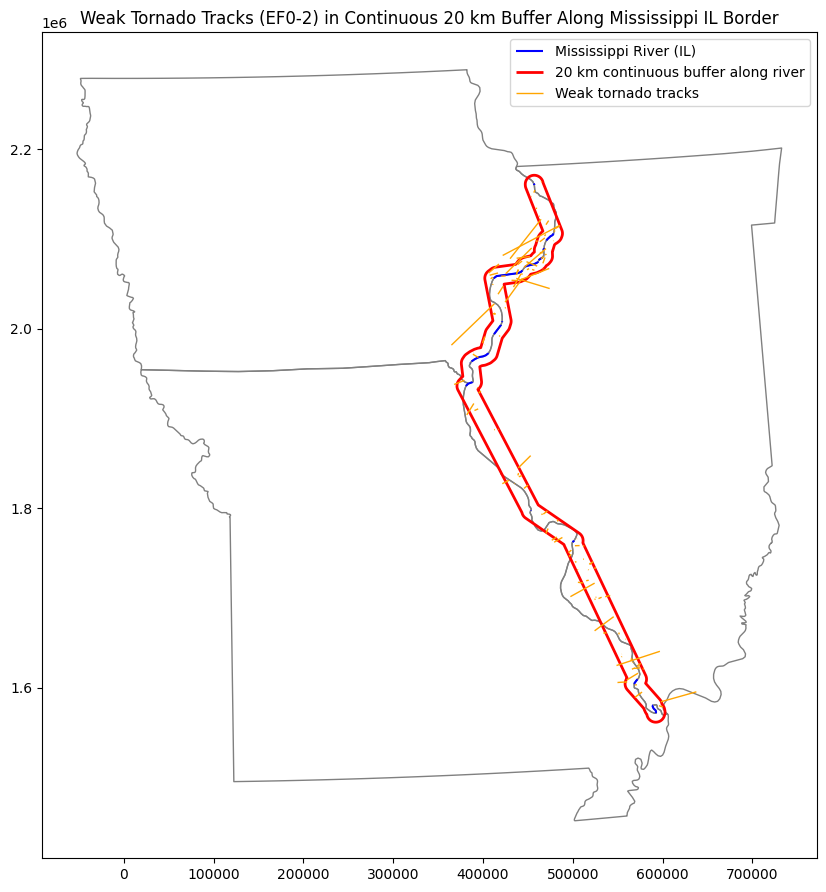

In [15]:
from shapely.geometry import LineString
from shapely.ops import unary_union

# Project river segments
mississippi_il_proj = mississippi_il.to_crs(proj_crs)

# Merge all geometries into one MultiLineString
river_multi = mississippi_il_proj.geometry.union_all()

# Extract all coordinates and sort by Y (north to south)
all_coords = []
for geom in river_multi.geoms if river_multi.geom_type == "MultiLineString" else [river_multi]:
    all_coords.extend(list(geom.coords))
# Sort coordinates by latitude (Y) descending (north to south)
all_coords_sorted = sorted(all_coords, key=lambda c: c[1], reverse=True)

# Create a continuous LineString from sorted coordinates
continuous_line = LineString(all_coords_sorted)

# Buffer 10 km each side
river_buffer_20km = continuous_line.buffer(10000)

# Select tornadoes intersecting this buffer
tornadoes_in_buffer = gdf_tornadoes[gdf_tornadoes.intersects(river_buffer_20km)]
tornadoes_counts_by_ef = tornadoes_in_buffer["mag"].value_counts().sort_index()

# --- Output ---
print("Tornadoes intersecting continuous 20 km buffer along IL Mississippi - total:", len(tornadoes_in_buffer))
print("Counts by EF-scale within buffer:")
print(tornadoes_counts_by_ef)

# --- Plot ---
fig, ax = plt.subplots(figsize=(10,12))
midwest_states.to_crs(proj_crs).plot(ax=ax, color="none", edgecolor="gray", linewidth=1)
mississippi_il_proj.plot(ax=ax, color="blue", label="Mississippi River (IL)")
gpd.GeoSeries([river_buffer_20km], crs=proj_crs).boundary.plot(ax=ax, color="red", linewidth=2, label="20 km continuous buffer along river")
tornadoes_in_buffer.plot(ax=ax, color="orange", linewidth=1, label="Weak tornado tracks")
ax.set_title("Weak Tornado Tracks (EF0-2) in Continuous 20 km Buffer Along Mississippi IL Border")
ax.legend()
plt.show()